# Explore the raw data for Guatemale pilot area
* Forest disturbances
* Land Use
* Rivers
* Roads
* Parks
* Urban Settlements

In [1]:
import geopandas as gpd
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import gdal
from rasterio import features

import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from datetime import datetime as dt
import fiona
from fiona.crs import from_epsg
from shapely.geometry import Point, mapping
from rasterstats import zonal_stats, point_query


## Globals

In [2]:
years = [2018, 2019, 2020]
data_disturbances = '/mnt/uksa-storage/guatemala/disturbances/'
guatemala_dir = '/mnt/uksa-storage/guatemala/'
data_lui = '/mnt/uksa-storage/land_cover'
data_rivers = 'rivers'
data_roads = '/mnt/uksa-storage/guatemala/roads'
data_parks = '/mnt/uksa-storage/guatemala/parks'
data_hansen = '/mnt/uksa-storage/guatemala/tree_cover'
data_border = '/mnt/uksa-storage/guatemala/border/'
data_srtm = f'{guatemala_dir}srtm'
data_population = f'{guatemala_dir}urban'
data_urban = '/mnt/uksa-storage/ESA_landuse'
data_merraclim = f'{guatemala_dir}merraclim/'
projection = 'EPSG:32615'
res_shp = 40
kms_per_radian = 6371.0088

## Helpers

In [3]:
def rasterize(shp, dst, feat, epsg):
    cmd = f'gdal_rasterize -a_srs {epsg} -a {feat} -tr 10 10 -ot Int32 -a_nodata 0 {shp} {dst}'
    os.system(cmd)
    return

def read_lui(filename, year, labels):
    """Read LUI and return class counts in dataframe"""
    rst = rasterio.open(filename)
    data = rst.read(1)
    a, b = np.unique(data, return_counts=True)
    df = pd.DataFrame(index =a)
    df['lui'] = df.index.map(labels)
    df['counts']=b
    df['year']=year
    return rst, data, df

def rasterize_nofeat(shp, dst, epsg, res):
    cmd = f'gdal_rasterize -burn 1 -a_srs {epsg} -tr {res} {res} -ot Int32 {shp} {dst}'
    os.system(cmd)
    return

def distance_to_value(target_value, source, outfile):
    cmd = f"gdal_proximity.py -co BIGTIFF=YES -co COMPRESS=LZW -maxdist 4000 -nodata 4001 -ot Int16 -values {target_value} {source} {outfile} "
    os.system(cmd)
    return

def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

def dbscan_reduce(df, epsilon, x='lon', y='lat'):
    start_time = time.time()
    # represent points consistently as (lat, lon) and convert to radians to fit using haversine metric
    # coords = df.as_matrix(columns=[y, x])    
    coords = df[[y, x]].values    
    db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    print('Number of clusters: {:,}'.format(num_clusters))
    
    clustered = pd.DataFrame(coords)
    clustered.columns = [y,x]
    clustered['cluster'] = cluster_labels

    
    return clustered


# 0. Border 

In [4]:
os.chdir(data_border)
border_shp ='gtm_admbnda_adm0_ocha_conred_20190207.shp'

In [5]:
border = gpd.read_file(border_shp)

In [6]:
border

,Shape_Leng,Shape_Area,ADM0_ES,ADM0_PCODE,ADM0_REF,ADM0ALT1ES,ADM0ALT2ES,date,validOn,validTo,geometry
0,21.92103,9.126107,Guatemala,GT,None,None,None,2018-09-25,2019-02-07,None,"POLYGON ((-89.15314 17.28058, -89.15299 17.249..."


<AxesSubplot:>

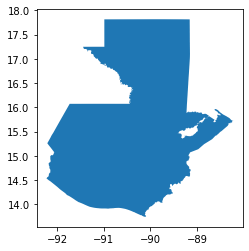

In [7]:
border.plot()

In [8]:

border.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
# change projection to mercautmtor
border= border.to_crs(projection)
new_nm='guatematela_border'
border.to_file(f'{new_nm}_utm.shp')

In [10]:
# rasterize
rasterize_nofeat(f'{new_nm}_utm.shp', f'{new_nm}.tif', projection, 40)

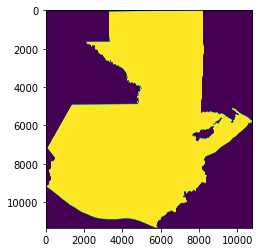

In [11]:
plt.imshow(rasterio.open(f'{new_nm}.tif').read(1))

# 1. Forest Disturbances

## Understand data

In [12]:
os.chdir(data_disturbances)

In [13]:
data = gpd.read_file('forestchange_footprint_current_change.shp')

In [14]:
data.shape

(34184, 6)

In [15]:
data.head()

,aoi,deliveryda,pkid,area_ha,enddate,geometry
0,1,20180202000000,40640,0.075333,20180202000000,"POLYGON ((-91.97514 15.50598, -91.97501 15.505..."
1,1,20180202000000,40641,0.037666,20180202000000,"POLYGON ((-91.97602 15.50698, -91.97615 15.506..."
2,1,20180202000000,40642,0.094164,20180202000000,"POLYGON ((-91.97539 15.51215, -91.97526 15.512..."
3,1,20180202000000,40643,0.075331,20180202000000,"POLYGON ((-91.97401 15.51227, -91.97413 15.512..."
4,1,20180202000000,40644,0.018833,20180202000000,"POLYGON ((-91.97325 15.50786, -91.97338 15.507..."


In [16]:
(data['deliveryda']==data['enddate']).sum()

34184

In [17]:
len(data['deliveryda'].unique())

75

In [18]:
data['deliveryda'].unique()

array(['20180202000000', '20180214000000', '20180226000000',
       '20180310000000', '20180322000000', '20180403000000',
       '20180415000000', '20180427000000', '20180509000000',
       '20180521000000', '20180602000000', '20180614000000',
       '20180626000000', '20180708000000', '20180720000000',
       '20180801000000', '20180813000000', '20180825000000',
       '20180906000000', '20180918000000', '20180930000000',
       '20181012000000', '20181024000000', '20181105000000',
       '20181117000000', '20181129000000', '20181211000000',
       '20181223000000', '20190104000000', '20190116000000',
       '20190128000000', '20190209000000', '20190221000000',
       '20190305000000', '20190317000000', '20190329000000',
       '20190410000000', '20190422000000', '20190504000000',
       '20190516000000', '20190528000000', '20190621000000',
       '20190703000000', '20190715000000', '20190727000000',
       '20190820000000', '20190925000000', '20191007000000',
       '20191019000000',

In [19]:
len(data['pkid'].unique())

34184

In [20]:
len(data['aoi'].unique())

1

In [21]:
# check projection 
data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [22]:
# change projection to mercator
data= data.to_crs(projection)


In [23]:
data.crs

<Projected CRS: EPSG:32615>
Name: WGS 84 / UTM zone 15N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 96°W to 90°W - by country
- bounds: (-96.0, 0.0, -90.0, 84.0)
Coordinate Operation:
- name: UTM zone 15N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

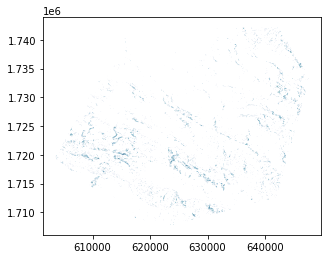

In [24]:
data.plot()

In [25]:
# only year
data['year'] = data['enddate'].str[:4]

In [26]:
a,b = np.unique(data['year'], return_counts = True)
print(a)
print(b)

['2018' '2019' '2020']
[16851 14374  2959]


In [27]:
# save shp
data.to_file('forest_change_mercator.shp')

In [28]:
data.groupby('year').aggregate(sum)

,pkid,area_ha
year,,
2018,826794315,638.501951
2019,929674385,458.482080
2020,217024896,82.441104


We note there has been much less deforestation in 2020 relative to the previous years

In [29]:
data.head()

,aoi,deliveryda,pkid,area_ha,enddate,geometry,year
0,1,20180202000000,40640,0.075333,20180202000000,"POLYGON ((609921.956 1714553.182, 609935.465 1...",2018
1,1,20180202000000,40641,0.037666,20180202000000,"POLYGON ((609826.861 1714664.203, 609813.352 1...",2018
2,1,20180202000000,40642,0.094164,20180202000000,"POLYGON ((609891.673 1715235.822, 609905.182 1...",2018
3,1,20180202000000,40643,0.075331,20180202000000,"POLYGON ((610040.200 1715250.467, 610026.692 1...",2018
4,1,20180202000000,40644,0.018833,20180202000000,"POLYGON ((610123.589 1714763.163, 610110.080 1...",2018


In [30]:
os.listdir()

['forestchange_footprint_current_change.cpg',
 'forestchange_footprint_current_change.dbf',
 'forestchange_footprint_current_change.prj',
 'forestchange_footprint_current_change.shp',
 'forestchange_footprint_current_change.shx',
 'forest_change_by_year.tif',
 'deforestation_2018.tif',
 'deforestation_2019.tif',
 'deforestation_2020.tif',
 'forest_change_mercator.shp',
 'forest_change_mercator.shx',
 'forest_change_mercator.dbf',
 'forest_change_mercator.cpg',
 'forest_change_mercator.prj']

## Rasterize data

In [31]:
# raster with all years
rasterize('forest_change_mercator.shp', 'forest_change_by_year.tif', 'year', 'EPSG:32615')

In [32]:
rst = rasterio.open('forest_change_by_year.tif')
rst.profile

{'driver': 'GTiff', 'dtype': 'int32', 'nodata': 0.0, 'width': 4401, 'height': 3440, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(10.0, 0.0, 603558.1124792217,
       0.0, -10.0, 1742194.128229793), 'tiled': False, 'interleave': 'band'}

In [33]:
rst_dt = rst.read(1)
a,b = np.unique(rst_dt, return_counts=True)

In [34]:
print(a)
print(b)

[   0 2018 2019 2020]
[15021061    64077    46052     8250]


The nb of 10x10m pixels matches the hectares deforested in the raw data - rasterization was succesful

## Raster masks by year

In [35]:
# deforestation mask per year - 1 binary raster for each year
with rasterio.open("forest_change_by_year.tif") as src:
    dst_profile = src.profile
    dst_profile.update(dtype=rasterio.int32, nodata=0)
    for yr in years:
        with rasterio.open(f"deforestation_{yr}.tif", 'w', **dst_profile) as dst:
            for ji, window in src.block_windows(1):
                r = np.array(src.read(1, window=window))
                m = r == yr
                dst.write(m.astype('int32'), window=window, indexes = 1)


In [36]:
# confirm the masks have been correctly produced
for yr in years:
    rst = rasterio.open(f"deforestation_{yr}.tif").read(1)
    print(f"In year {yr} there were {sum(sum(rst))} pixels deforested")

In year 2018 there were 64077 pixels deforested
In year 2019 there were 46052 pixels deforested
In year 2020 there were 8250 pixels deforested


# 2. Land Use

In [5]:
os.chdir(data_lui)

In [6]:
# LABELS
# let's see what the class labels correspond to
with open('GSI_LandNow_LCC_Delivery_2_ColourMap.clr') as f:
    lines = f.readlines()
    
labels = {}
for l in lines:
    labels.update({int(l.split(' ')[0]):l.split(' ')[-2]})
labels.update({11:'coffee'})
labels.update({-9999:'outside AOI'})

print(labels)

{1: 'Shrubs', 2: 'Vegetation', 3: 'Cropland', 4: 'Urban', 5: 'vegetation', 7: 'body', 8: 'wetland', 9: 'Lichen', 10: 'Forest', 11: 'coffee', -9999: 'outside AOI'}


## Raw folder

In [39]:
# raw data from 2020
rst_raw_20, dt_raw_20, df_raw_20  = read_lui('2020/Raw/GSI_LandNow_LCC_2020_Iteration_2.tif', 2020, labels)

In [40]:
rst_raw_20.profile

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 4447, 'height': 3569, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(10.0, 0.0, 603310.0,
       0.0, -10.0, 1742400.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

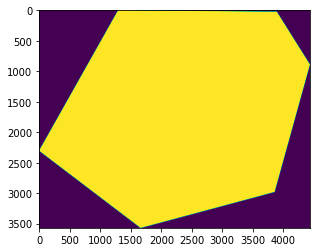

In [41]:
plt.imshow(dt_raw_20)

In [42]:
df_raw_20

,lui,counts,year
-9999,outside AOI,4427012,2020
1,Shrubs,250636,2020
2,Vegetation,116148,2020
3,Cropland,1404038,2020
4,Urban,206814,2020
5,vegetation,291522,2020
7,body,11177,2020
10,Forest,6348670,2020
11,coffee,2815326,2020


In [43]:
# raw data from 2017
rst_raw_17, dt_raw_17, df_raw_17  = read_lui('2017/Raw/GSI_LandNow_LCC_2017_Iteration_2.tif', 2017, labels)

In [44]:
rst_raw_17.profile

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 4447, 'height': 3569, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(10.0, 0.0, 603310.0,
       0.0, -10.0, 1742400.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

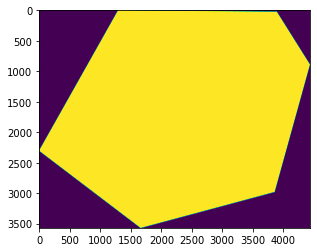

In [45]:
plt.imshow(dt_raw_17)

In [46]:
df_raw_17

,lui,counts,year
-9999,outside AOI,4427012,2017
1,Shrubs,372140,2017
2,Vegetation,226316,2017
3,Cropland,1466284,2017
4,Urban,235404,2017
5,vegetation,280857,2017
7,body,11752,2017
10,Forest,5649376,2017
11,coffee,3202202,2017


In [47]:
# confirm the AOI is the same in 2017 and 2020
df_raw_17['counts'].sum()==df_raw_20['counts'].sum()

True

In [48]:
# combine both years
raw_lui_combined = df_raw_17.append(df_raw_20)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'outside AOI'),
  Text(1, 0, 'Shrubs'),
  Text(2, 0, 'Vegetation'),
  Text(3, 0, 'Cropland'),
  Text(4, 0, 'Urban'),
  Text(5, 0, 'vegetation'),
  Text(6, 0, 'body'),
  Text(7, 0, 'Forest'),
  Text(8, 0, 'coffee')])

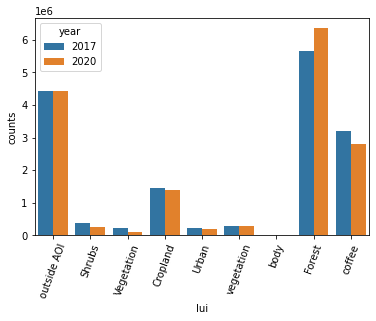

In [49]:
# Plot the counts in 2017 and 2020
ax = sns.barplot(x='lui', y='counts', hue='year', data = raw_lui_combined)
plt.xticks(rotation=70)

We note that total forest cover has increased between 2017 and 2020, as a result of a reduction in land cultivation: cropland and coffee classes are in dedcline

## Smoothed folder

In [50]:
# smoothed data from 2020
rst_smooth_20, dt_smooth_20, df_smooth_20  = read_lui('2020/Smoothed/GSI_LandNow_LCC_2020_Iteration_2_Smoothed.tif', 2020, labels)



In [51]:
rst_raw_20.profile

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 4447, 'height': 3569, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(10.0, 0.0, 603310.0,
       0.0, -10.0, 1742400.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

In [52]:
df_raw_20

,lui,counts,year
-9999,outside AOI,4427012,2020
1,Shrubs,250636,2020
2,Vegetation,116148,2020
3,Cropland,1404038,2020
4,Urban,206814,2020
5,vegetation,291522,2020
7,body,11177,2020
10,Forest,6348670,2020
11,coffee,2815326,2020


In [53]:
# smoothed data from 2017
rst_smooth_17, dt_smooth_17, df_smooth_17  = read_lui('2017/Smoothed/GSI_LandNow_LCC_2017_Iteration_2_Smoothed.tif', 2017, labels)


In [54]:
# combine both years
smooth_lui_combined = df_smooth_17.append(df_smooth_20)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'outside AOI'),
  Text(1, 0, 'Shrubs'),
  Text(2, 0, 'Vegetation'),
  Text(3, 0, 'Cropland'),
  Text(4, 0, 'Urban'),
  Text(5, 0, 'vegetation'),
  Text(6, 0, 'body'),
  Text(7, 0, 'Forest'),
  Text(8, 0, 'coffee')])

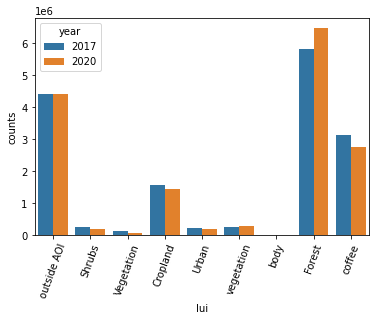

In [55]:
# Plot the counts in 2017 and 2020
ax = sns.barplot(x='lui', y='counts', hue='year', data = smooth_lui_combined)
plt.xticks(rotation=70)

We just use the smoothed LUI. Note that we'll train the model using the 2017 LUI, BUT make the projections for 2021 using the 2020 forest cover!

In [16]:
os.listdir()

['GSI_LandNow_LCC_Delivery_2_ColourMap.clr',
 'readme.txt',
 '2017',
 '2020',
 'rivers_gtm_utm.shp',
 'rivers_gtm_utm.shx',
 'rivers_gtm_utm.dbf',
 'rivers_gtm_utm.cpg',
 'rivers_gtm_utm.prj',
 'rivers_gtm.tif',
 'distance_rivers_gtm.tif',
 'pilot_guatemala_aoi.tif',
 'forest_mask.tif',
 'forest_mask_2017.tif',
 'forest_mask_2020.tif']

## Forest masks

In [15]:
## Forest masks
for year in ['2017', '2020']:
    with rasterio.open(f'{year}/Smoothed/GSI_LandNow_LCC_{year}_Iteration_2_Smoothed.tif') as src:
        profile = src.profile
        with rasterio.open(f'forest_mask_{year}.tif', 'w', **profile) as dst:
            data = src.read(1)
            data = np.where(data==10, 1, 0)
            data.dtype='int16'
            dst.write(data, indexes =1)

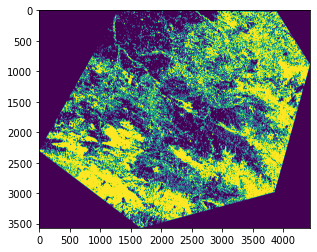

In [17]:
plt.imshow(rasterio.open('forest_mask_2017.tif').read(1))

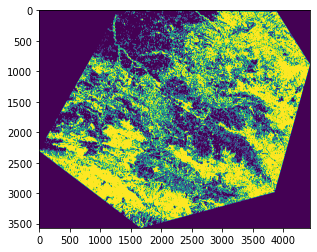

In [18]:
plt.imshow(rasterio.open('forest_mask_2020.tif').read(1))

## Zonal stats

In [11]:
stats = zonal_stats("/mnt/uksa-storage/guatemala/disturbances/forestchange_footprint_current_change.shp",
                    "forest_mask_2017.tif",
                     stats="sum")

In [12]:
stats

[{'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': None},
 {'median': 

# 3. Area of Interet AOI
Derive a raster and a shapefile of the area of interest for the pilot DRI


In [56]:
# deforestation mask per year - 1 binary raster for each year
with rasterio.open('2017/Raw/GSI_LandNow_LCC_2017_Iteration_2.tif') as src:
    dst_profile = src.profile
    dst_profile.update(dtype=rasterio.int32, nodata=0)
    with rasterio.open("pilot_guatemala_aoi.tif", 'w', **dst_profile) as dst:
        for ji, window in src.block_windows(1):
            r = np.array(src.read(1, window=window))
            m = r >0
            dst.write(m.astype('int32'), window=window, indexes = 1)


In [57]:
dst = rasterio.open("pilot_guatemala_aoi.tif").read(1)

In [58]:
a, b = np.unique(dst, return_counts = True)
print(a)
print(b)

[0 1]
[ 4427012 11444331]


The number of AOI pixels matches the table above - all OK

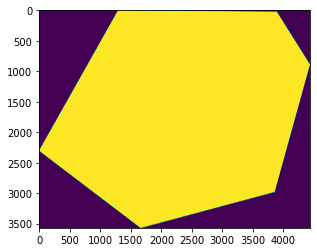

In [59]:
plt.imshow(dst)

# 4. Rivers
Let's explore the river data

In [60]:
os.chdir(guatemala_dir+data_rivers)

In [61]:
rivers = gpd.read_file('rios_gtm.shp')

In [62]:
rivers.crs

<Projected CRS: PROJCS["Transverse_Mercator",GEOGCS["GCS_WGS_1984" ...>
Name: Transverse_Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: unknown
- Ellipsoid: WGS84
- Prime Meridian: Greenwich

In [63]:
# change projection to mercator
rivers= rivers.to_crs(projection)
rivers.to_file('rivers_gtm_utm.shp')

In [64]:
rivers.crs

<Projected CRS: EPSG:32615>
Name: WGS 84 / UTM zone 15N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 96°W to 90°W - by country
- bounds: (-96.0, 0.0, -90.0, 84.0)
Coordinate Operation:
- name: UTM zone 15N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [65]:
rivers.head()

,gid,codigo,nombre,largo,naturaleza,tipo,geometry
0,1,8087,Sin Nombre,100.339636,0,0,"LINESTRING (749182.302 1555528.559, 749202.427..."
1,2,8090,Sin Nombre,294.270563,0,0,"LINESTRING (749182.302 1555528.559, 749174.865..."
2,3,8122,Canal,587.998245,0,0,"LINESTRING (659266.506 1554404.380, 659263.943..."
3,4,8088,Sin Nombre,415.201198,0,0,"LINESTRING (749373.490 1555846.560, 749349.427..."
4,5,8120,Rio Los Esclavos,3799.873026,0,0,"LINESTRING (787107.524 1557000.592, 787109.462..."


In [66]:
rivers['tipo'].unique()

array([0])

In [67]:
rivers['naturaleza'].unique()

array([0])

<AxesSubplot:>

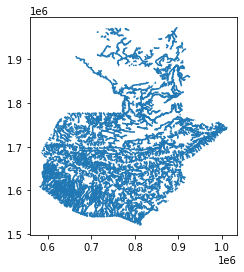

In [68]:
rivers.plot()

In [69]:
# rasterize
rasterize_nofeat('rivers_gtm_utm.shp', 'rivers_gtm.tif', projection, res_shp)


In [70]:
# confirm rasterization
dst = rasterio.open('rivers_gtm.tif').read(1)

In [71]:
dst.shape

(11330, 10766)

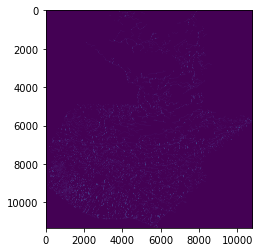

In [72]:
plt.imshow(dst)

In [73]:
sum(sum(dst))

626574

In [74]:
np.unique(dst)

array([0, 1], dtype=int32)

In [75]:
# distance to rivers
distance_to_value(1, 'rivers_gtm.tif', 'distance_rivers_gtm.tif')

In [76]:
rasterio.open('distance_rivers_gtm.tif').profile

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 10766, 'height': 11330, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(40.0, 0.0, 581832.4146104993,
       0.0, -40.0, 1973954.2797119063), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}

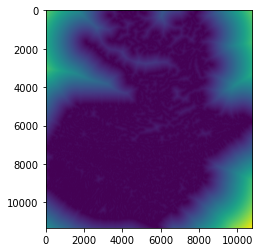

In [77]:
plt.imshow(rasterio.open('distance_rivers_gtm.tif').read(1))

# 5. Roads

In [78]:
os.chdir(data_roads)

In [79]:
roads = gpd.read_file('caminos_gtm.shp')

In [80]:
roads.crs

<Projected CRS: PROJCS["Transverse_Mercator",GEOGCS["GCS_WGS_1984" ...>
Name: Transverse_Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: unknown
- Ellipsoid: WGS84
- Prime Meridian: Greenwich

In [81]:
# change projection to mercator
roads= roads.to_crs(projection)
roads.to_file('roads_gtm_utm.shp')

In [82]:
roads.crs

<Projected CRS: EPSG:32615>
Name: WGS 84 / UTM zone 15N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 96°W to 90°W - by country
- bounds: (-96.0, 0.0, -90.0, 84.0)
Coordinate Operation:
- name: UTM zone 15N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [83]:
# rasterize
rasterize_nofeat('roads_gtm_utm.shp', 'roads_gtm.tif',projection, res_shp)


In [84]:
# confirm rasterization
dst = rasterio.open('roads_gtm.tif').read(1)

In [85]:
dst.shape

(13216, 10834)

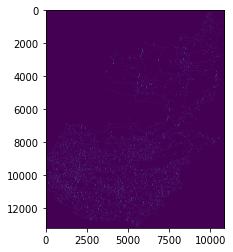

In [86]:
plt.imshow(dst)

In [87]:
sum(sum(dst))

891985

In [88]:
# distance to raods
distance_to_value(1, 'roads_gtm.tif', 'distance_roads_gtm.tif')

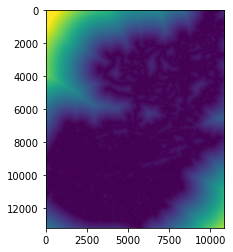

In [89]:
plt.imshow(rasterio.open('distance_roads_gtm.tif').read(1))

# 6. Parks


In [90]:
os.chdir(data_parks)
os.listdir()

['Administrative_Units_Maya_Forest_Guatemala.cpg',
 'Administrative_Units_Maya_Forest_Guatemala.dbf',
 'Administrative_Units_Maya_Forest_Guatemala.prj',
 'Administrative_Units_Maya_Forest_Guatemala.shp',
 'Administrative_Units_Maya_Forest_Guatemala.shx',
 'Administrative_Units_Maya_Forest_Guatemala.xml',
 'SIGAP_protected_areas.cpg',
 'SIGAP_protected_areas.dbf',
 'SIGAP_protected_areas.prj',
 'SIGAP_protected_areas.sbn',
 'SIGAP_protected_areas.sbx',
 'SIGAP_protected_areas.shp',
 'SIGAP_protected_areas.shx',
 'SIGAP_protected_areas_utm.shp',
 'SIGAP_protected_areas_utm.dbf',
 'SIGAP_protected_areas_utm.prj',
 'test.tif',
 'parque_nacional.tif',
 'parque_regional_municipal.tif',
 'reserva_natural_privada.tif',
 'biotopo_protegido.tif',
 'reserva_de_la_biosfera.tif',
 'reserva_biológica.tif',
 'refugio_de_vida_silvestre.tif',
 'monumento_cultural.tif',
 'reserva_de_uso_multiple.tif',
 'zona_de_veda_definitiva.tif',
 'area_de_uso_multiple.tif',
 'reserva_protectora_de_manantiales.tif',


In [91]:
parks = gpd.read_file('Administrative_Units_Maya_Forest_Guatemala.shp')

In [92]:
parks.shape

(14, 6)

In [93]:
parks.head()

,FID,AREA,PERIMETER,AP_NOM,CAT_MAN,geometry
0,1,163927900,143688.80,Reserva de Biosfera Maya,Zona de Uso Múltiple,"POLYGON ((-90.96211 17.81459, -90.96745 17.338..."
1,2,2902431000,445443.70,Laguna del Tigre,Parque Nacional,"POLYGON ((-90.45490 17.16699, -90.45516 17.167..."
2,3,7699829000,824599.50,Reserva de Biosfera Maya,Zona de Uso Múltiple,"POLYGON ((-89.50047 16.94693, -89.50159 17.057..."
3,4,1174727000,235759.50,Mirador-Río Azul,Parque Nacional,"POLYGON ((-89.76667 17.81461, -89.76667 17.770..."
4,5,296426300,79632.99,Naachtún Dos Lagunas,Biotopo,"POLYGON ((-89.76667 17.81461, -89.50000 17.814..."


<AxesSubplot:>

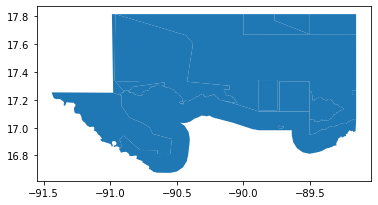

In [94]:
parks.plot()

This map only covers a small area of the country - the North East

In [95]:
parks = gpd.read_file('SIGAP_protected_areas.shp')

In [96]:
parks.shape

(420, 9)

In [97]:
parks.head()


,codigo_gra,codigo_esp,CÓDIGO,NOMBRE_Gra,Categor_1,CÓDIGO_1,NOMBRE_esp,Categor_12,geometry
0,69,69,69.0,Sipacate - Naranjo,Parque Nacional,69.0,Sipacate - Naranjo,Parque Nacional,"POLYGON Z ((443823.982 1541396.900 0.000, 4442..."
1,365,365,365.0,Bosque la Avanzada,Parque Regional Municipal,365.0,Bosque la Avanzada,Parque Regional Municipal,"POLYGON Z ((332597.000 1690773.000 0.000, 3326..."
2,362,362,362.0,Covirey,Parque Regional Municipal,362.0,Covirey,Parque Regional Municipal,"POLYGON Z ((396574.000 1737013.000 0.000, 3971..."
3,366,366,366.0,Joya Grande,Parque Regional Municipal,366.0,Joya Grande,Parque Regional Municipal,MULTIPOLYGON Z (((453520.248 1597896.018 0.000...
4,147,147,147.0,Niño Dormido,Parque Regional Municipal,147.0,Niño Dormido,Parque Regional Municipal,"POLYGON Z ((575464.998 1649271.619 0.000, 5752..."


<AxesSubplot:>

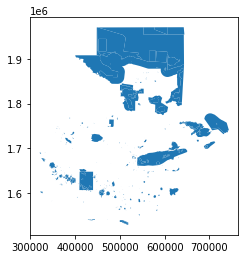

In [98]:
parks.plot()

In [99]:
parks.Categor_1.unique()

array(['Parque Nacional', 'Parque Regional Municipal',
       'Reserva Natural Privada', 'Zona de Veda Definitiva',
       'Reserva de la Biosfera', 'Reserva Biológica',
       'Refugio de Vida Silvestre', 'Monumento Cultural',
       'Reserva de Uso Multiple', 'Biotopo Protegido',
       'Area de Uso Multiple', 'Reserva Protectora de Manantiales',
       'Reserva Forestal Protectora de Manantiales',
       'Parque Regional y Área Natural Recreativa', 'Monumento Natural',
       'Reserva Forestal Municipal',
       'Parque Recreativo Natural Municipal', None,
       'Reserva Hídrica y Forestal', 'Área de Usos Múltiples',
       'Parque Regional'], dtype=object)

In [100]:
parks.Categor_12.unique()

array(['Parque Nacional', 'Parque Regional Municipal',
       'Reserva Natural Privada', 'Biotopo Protegido',
       'Reserva de la Biosfera', 'Reserva Biológica',
       'Refugio de Vida Silvestre', 'Monumento Cultural',
       'Reserva de Uso Multiple', 'Zona de Veda Definitiva',
       'Area de Uso Multiple', 'Reserva Protectora de Manantiales',
       'Reserva Forestal Protectora de Manantiales',
       'Parque Regional y Área Natural Recreativa', 'Monumento Natural',
       'Reserva Forestal Municipal',
       'Parque Recreativo Natural Municipal', None,
       'Reserva Hídrica y Forestal', 'Área de Usos Múltiples',
       'Parque Regional'], dtype=object)

The attribute 'Categor_12' seems to have the more detailed specification of the protected area type

In [101]:
parks.Categor_12.fillna("undefined",inplace=True)

In [102]:
protected_area_type=list(parks.Categor_12.unique())

In [103]:
parks.crs

<Projected CRS: PROJCS["GTM",GEOGCS["GCS_WGS_1984",DATUM["WGS_1984 ...>
Name: GTM
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS_84
- Prime Meridian: Greenwich

In [104]:
# change projection to UTM
parks= parks.to_crs(projection)
parks.to_file('SIGAP_protected_areas_utm.shp')

In [105]:
parks.crs

<Projected CRS: EPSG:32615>
Name: WGS 84 / UTM zone 15N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 96°W to 90°W - by country
- bounds: (-96.0, 0.0, -90.0, 84.0)
Coordinate Operation:
- name: UTM zone 15N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

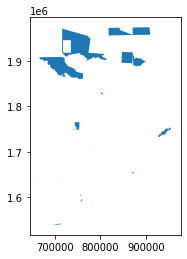

In [106]:
# plot only National parks
parks[parks.Categor_12=='Parque Nacional'].plot()

In [107]:
# Profile to save the raster
meta =rasterio.open('../border/guatematela_border.tif').meta.copy()
meta.update({'dtype':'int8'})
meta

{'driver': 'GTiff',
 'dtype': 'int8',
 'nodata': None,
 'width': 10766,
 'height': 11334,
 'count': 1,
 'crs': CRS.from_epsg(32615),
 'transform': Affine(40.0, 0.0, 581832.4374568379,
        0.0, -40.0, 1974127.2501024674)}

In [108]:
# rasteriza all parks
with rasterio.open(f'SIGAP_protected_areas.tif', 'w', **meta) as out:
    # this is where we create a generator of geom, value pairs to use in rasterizing
    shp = ((geom,1) for geom in parks.geometry)
    dims = (out.profile['width'], out.profile['height'])

    burned = features.rasterize(shapes=shp, out_shape = dims, fill=0, transform=out.transform)
    burned.dtype=meta['dtype']
    out.write_band(1, burned)

In [109]:
# rasterize each park type
try:
    os.mkdir('processed')
    
except:
    FileExistsError
    
for area in protected_area_type:
    name = area.replace(' ', '_').lower()
    
    with rasterio.open(f'processed/area_feat_{name}.tif', 'w', **meta) as out:
        # this is where we create a generator of geom, value pairs to use in rasterizing
        shp = ((geom,1) for geom in parks[parks.Categor_12==area].geometry)
        dims = (out.profile['width'], out.profile['height'])

        burned = features.rasterize(shapes=shp, out_shape = dims, fill=0, transform=out.transform)
        burned.dtype=meta['dtype']
        out.write_band(1, burned)

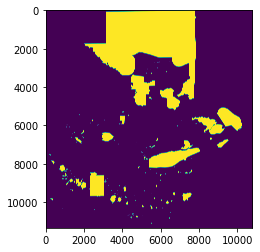

In [110]:
plt.imshow(rasterio.open('SIGAP_protected_areas.tif').read(1))

<AxesSubplot:>

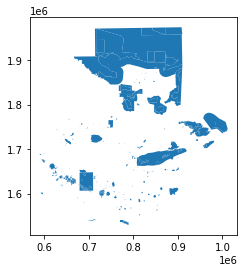

In [111]:
parks.plot()

# 7. SRTM

In [112]:
os.chdir(data_srtm)
os.listdir()

['Old',
 'im',
 'srtm_18_09.zip',
 'srtm_18_10.zip',
 'srtm_19_09.zip',
 'srtm_19_10.zip',
 'SOURCE.txt',
 'srtm_18_09.hdr',
 'srtm_18_09.tfw',
 'srtm_18_09.tif',
 'srtm_18_10.hdr',
 'srtm_18_10.tfw',
 'srtm_18_10.tif',
 'srtm_19_09.hdr',
 'srtm_19_09.tfw',
 'srtm_19_09.tif',
 'readme.txt',
 'srtm_19_10.hdr',
 'srtm_19_10.tfw',
 'srtm_19_10.tif',
 'srtm_guatemala.tif',
 'processed',
 'slope_guatemala.tif',
 'roughness_guatemala.tif',
 'TRI_guatemala.tif']

In [113]:
srtm = rasterio.open('srtm_guatemala.tif')
srtm.profile

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 12000, 'height': 12000, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0008333333333333334, 0.0, -95.0,
       0.0, -0.0008333333333333334, 20.0), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}

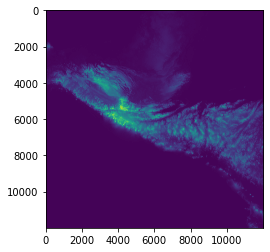

In [114]:
plt.imshow(srtm.read(1))

In [115]:
data_srtm

'/mnt/uksa-storage/guatemala/srtm'

In [116]:
try:
    os.mkdir('processed')
    
except:
    FileExistsError
    
# Get slope, roughness and rudgeness (TRI)
!gdaldem slope -s 111120 -alg ZevenbergenThorne -compute_edges srtm_guatemala.tif slope_guatemala.tif
!gdaldem roughness -alg ZevenbergenThorne -compute_edges srtm_guatemala.tif roughness_guatemala.tif
!gdaldem TRI -alg ZevenbergenThorne -compute_edges srtm_guatemala.tif  TRI_guatemala.tif




0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


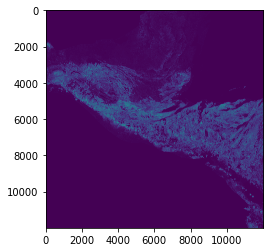

In [117]:
plt.imshow(rasterio.open('slope_guatemala.tif').read(1))

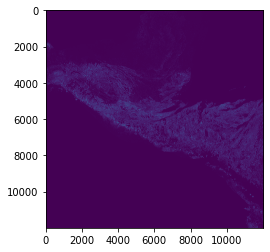

In [118]:
plt.imshow(rasterio.open('roughness_guatemala.tif').read(1))

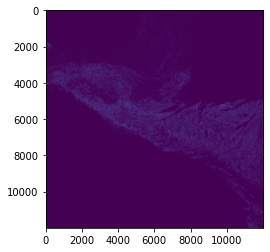

In [119]:
plt.imshow(rasterio.open('TRI_guatemala.tif').read(1))

# 8. Urban Settlements
## 8.1 Exploration

In [4]:
os.chdir(data_population)
os.listdir()

['hrsl_gtm_settlement.tfw',
 'hrsl_gtm_settlement.tif',
 'hrsl_gtm_settlement.tif.aux.xml',
 'hrsl_gtm_settlement.tif.ovr',
 'hrsl_gtm_settlement.tif.vat.cpg',
 'hrsl_gtm_settlement.tif.vat.dbf',
 'hrsl_gtm_settlement.tif.xml',
 'hrsl_gtm_settlement_metadata.html',
 'hrsl_gtm_settlement_xslttran1.xml',
 'ReleaseNotes20180316.txt',
 'gtm_acq_date_cc.cpg',
 'gtm_acq_date_cc.dbf',
 'gtm_acq_date_cc.prj',
 'gtm_acq_date_cc.sbn',
 'gtm_acq_date_cc.sbx',
 'gtm_acq_date_cc.shp',
 'gtm_acq_date_cc.shp.xml',
 'gtm_acq_date_cc.shx',
 'hrsl_gtm_pop.tif',
 'hrsl_gtm_pop.tif.aux.xml',
 'hrsl_gtm_pop.tif.xml',
 'hrsl_gtm_pop_metadata.html',
 'hrsl_gtm_pop_xslttransformat1.xml',
 'tmp',
 'gdal2xyz.py',
 'test.tif',
 'settlements_population_over_1000.tif',
 'settlements_population_over_2000.tif',
 'settlements_population_over_5000.tif',
 'settlements_population_over_10000.tif',
 'hrsl_pop_no_nan.tif',
 'pop_raster_no_nan_downscaled_quarter.tif',
 'pop_raster_no_nan_downscaled.tif']

In [5]:
pop_raster = 'hrsl_gtm_pop.tif'
settle=rasterio.open(pop_raster)

In [6]:
settle.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 14382, 'height': 14688, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, -92.22236111111111,
       0.0, -0.0002777777777777778, 17.818749999999998), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [7]:
pop = settle.read(1)

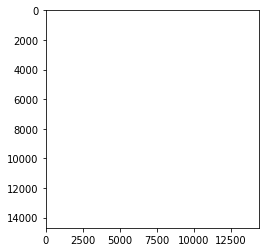

In [8]:
plt.imshow(pop)

Most of the entries are missing, let's replace NAs with -9999

In [26]:
# rename new raster
pop_raster_no_nan = 'hrsl_pop_no_nan.tif'
# remove NAs

with rasterio.open(pop_raster) as src:
    profile = src.profile
    nodata = -9999
    profile.update({'nodata':nodata})
    with rasterio.open(pop_raster_no_nan, 'w', **profile) as dst:
        for ij, window in src.block_windows(1):
            raw = np.array(src.read(1, window=window))
            data = np.nan_to_num(raw, nodata)
            
            dst.write(data, window=window, indexes=1)
        
        

In [27]:
settle = rasterio.open(pop_raster_no_nan)
settle.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 14382, 'height': 14688, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, -92.22236111111111,
       0.0, -0.0002777777777777778, 17.818749999999998), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [28]:
pop = settle.read(1)

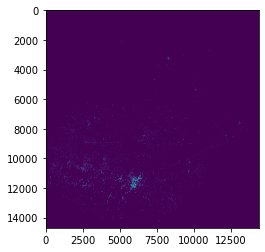

In [29]:
plt.imshow(pop)

In [30]:
pop[pop>0].sum().sum()

16342903.0

The population raster is now operational, let's apply the debscan clustering algorithm to idedntify major population clusters

In [36]:
# let's reduce the resolution of the raster by half - to retrive the population, we need to multiply each entry by 4
cmd = f"gdalwarp -ts {int(settle.profile['width']/4)} {int(settle.profile['height']/4)} -r average -overwrite {pop_raster_no_nan} pop_raster_no_nan_downscaled_quarter.tif"
print(cmd)
os.system(cmd)
# multiply by 4
cmd = f"gdal_calc.py --calc=16*A  -A pop_raster_no_nan_downscaled_quarter.tif --outfile=pop_raster_no_nan_downscaled.tif --overwrite"
print(cmd)
os.system(cmd)


gdalwarp -ts 3595 3672 -r average -overwrite hrsl_pop_no_nan.tif pop_raster_no_nan_downscaled_quarter.tif
gdal_calc.py --calc=16*A  -A pop_raster_no_nan_downscaled_quarter.tif --outfile=pop_raster_no_nan_downscaled.tif --overwrite


0

In [37]:
a =rasterio.open('pop_raster_no_nan_downscaled_quarter.tif').read(1)

In [38]:
a.sum().sum()

1021276.9

In [39]:
a =rasterio.open('pop_raster_no_nan_downscaled.tif').read(1)

In [40]:
a.sum().sum()

16340430.0

## 8.2 Population clusters

**NOTE**: This section takes a long time to run. The clustering operation is conducted on the large population raster. Only run this once.

In [41]:
%matplotlib inline
# copy gdal2xyz.py to directory
os.system('cp /home/pablo/forest_mind/analysis/gdal2xyz.py gdal2xyz.py')
try:
    os.mkdir('tmp')
    
except:
    FileExistsError
    
# Write out the coordinates of the pixels non zero data 
#cmd=f'./gdal2xyz.py -band 1 {pop_raster_no_nan} -csv > tmp/hrsl_coords.txt'
#os.system(cmd)

cmd=f'./gdal2xyz.py -band 1 pop_raster_no_nan_downscaled.tif -csv > tmp/hrsl_coords_downscaled.txt'
os.system(cmd)


0

In [42]:
df_gps = pd.read_csv('tmp/hrsl_coords_downscaled.txt', names = ['lon','lat','pop'])


In [43]:
df_gps.shape

(13200840, 3)

In [26]:
df_gps.shape

(52810704, 3)

In [160]:
df_gps.shape

(211242816, 3)

In [156]:
df_gps.head()

,lon,lat,pop
0,-92.222222,17.818611,0.0
1,-92.221944,17.818611,0.0
2,-92.221667,17.818611,0.0
3,-92.221389,17.818611,0.0
4,-92.221111,17.818611,0.0


In [164]:
df_gps['pop'].sum()

16342898.672124976

In [169]:
#Do clustering
eps_rad = 0.25 / kms_per_radian
df_clustered = dbscan_reduce(df_gps, epsilon=eps_rad)

MemoryError: Unable to allocate 3.15 GiB for an array with shape (211242816, 2) and data type float64

In [ ]:
#Add a column of the within-cluster population
df_clustered['pop'] = df_gps['pop']
df_clustered['cluster_pop'] = df_clustered['pop'].groupby(df_clustered['cluster']).transform('sum')

head(df_clustered)

In [146]:
#Write to CSV
df_clustered = df_clustered.sort_values(by=['lat', 'lon'])
df_clustered.to_csv('tmp/hrsl_clustered.csv', index = False)

'/mnt/uksa-storage/guatemala/urban'

In [ ]:
#Create various filtered data frames

df_clusters_over_1000 = df_clustered.loc[df_clustered['cluster_pop'] >= 1000].sort_values(by=['lat', 'lon'])
df_clusters_over_2000 = df_clustered.loc[df_clustered['cluster_pop'] >= 2000].sort_values(by=['lat', 'lon'])
df_clusters_over_5000 = df_clustered.loc[df_clustered['cluster_pop'] >= 5000].sort_values(by=['lat', 'lon'])
df_clusters_over_10000 = df_clustered.loc[df_clustered['cluster_pop'] >= 10000].sort_values(by=['lat', 'lon'])
df_clusters_over_20000 = df_clustered.loc[df_clustered['cluster_pop'] >= 20000].sort_values(by=['lat', 'lon'])

df_clusters_over_1000['settlement'] = 1
df_clusters_over_2000['settlement'] = 1
df_clusters_over_5000['settlement'] = 1
df_clusters_over_10000['settlement'] = 1
df_clusters_over_20000['settlement'] = 1


In [ ]:
#Write out to shapefiles
with fiona.open('tmp/clusters_over_10000.shp', 'w',crs=from_epsg(4326),driver='ESRI Shapefile', schema=my_schema) as output:
    for index, row in df_clusters_over_10000.iterrows():
        point = Point(float(row['lon']), float(row['lat']))

        output.write({
                'properties': {},
                'geometry': mapping(point)
            })

       
with fiona.open('tmp/clusters_over_5000.shp', 'w',crs=from_epsg(4326),driver='ESRI Shapefile', schema=my_schema) as output:
    for index, row in df_clusters_over_5000.iterrows():
        point = Point(float(row['lon']), float(row['lat']))

        output.write({
                'properties': {},
                'geometry': mapping(point)
            })

with fiona.open('tmp/clusters_over_2000.shp', 'w',crs=from_epsg(4326),driver='ESRI Shapefile', schema=my_schema) as output:
    for index, row in df_clusters_over_2000.iterrows():
        point = Point(float(row['lon']), float(row['lat']))

        output.write({
                'properties': {},
                'geometry': mapping(point)
            })

with fiona.open('tmp/clusters_over_1000.shp', 'w',crs=from_epsg(4326),driver='ESRI Shapefile', schema=my_schema) as output:
    for index, row in df_clusters_over_1000.iterrows():
        point = Point(float(row['lon']), float(row['lat']))

        output.write({
                'properties': {},
                'geometry': mapping(point)
            })


In [ ]:
#Use gdal_rasterize to write out TIFFs

!gdal_rasterize -burn 1 -ot Byte -ts 23663 23147 -te  -8.6997869 4.3469286 -2.1267313 10.7766508 -co COMPRESS=LZW    -a_nodata 0  -l clusters_over_1000 tmp/clusters_over_1000.shp settlements_population_over_1000.tif
!gdal_rasterize -burn 1 -ot Byte -ts 23663 23147 -te  -8.6997869 4.3469286 -2.1267313 10.7766508 -co COMPRESS=LZW    -a_nodata 0  -l clusters_over_2000 tmp/clusters_over_2000.shp settlements_population_over_2000.tif
!gdal_rasterize -burn 1 -ot Byte -ts 23663 23147 -te  -8.6997869 4.3469286 -2.1267313 10.7766508 -co COMPRESS=LZW    -a_nodata 0  -l clusters_over_5000 tmp/clusters_over_5000.shp settlements_population_over_5000.tif
!gdal_rasterize -burn 1 -ot Byte -ts 23663 23147 -te  -8.6997869 4.3469286 -2.1267313 10.7766508 -co COMPRESS=LZW    -a_nodata 0  -l clusters_over_10000 tmp/clusters_over_10000.shp settlements_population_over_10000.tif
!gdal_rasterize -burn 1 -ot Byte -ts 23663 23147 -te  -8.6997869 4.3469286 -2.1267313 10.7766508 -co COMPRESS=LZW    -a_nodata 0  -l clusters_over_20000 tmp/clusters_over_20000.shp settlements_population_over_20000.tif


# 9. Merraclim

In [158]:
os.chdir(data_merraclim)
os.listdir()

['2_5m_mean_00s_bio1.tif',
 '2_5m_mean_00s_bio2.tif',
 '2_5m_mean_00s_bio3.tif',
 '2_5m_mean_00s_bio4.tif',
 '2_5m_mean_00s_bio5.tif',
 '2_5m_mean_00s_bio6.tif',
 '2_5m_mean_00s_bio7.tif',
 '2_5m_mean_00s_bio8.tif',
 '2_5m_mean_00s_bio9.tif',
 '2_5m_mean_00s_bio10.tif',
 '2_5m_mean_00s_bio11.tif',
 '2_5m_mean_00s_bio12.tif',
 '2_5m_mean_00s_bio13.tif',
 '2_5m_mean_00s_bio14.tif',
 '2_5m_mean_00s_bio15.tif',
 '2_5m_mean_00s_bio16.tif',
 '2_5m_mean_00s_bio17.tif',
 '2_5m_mean_00s_bio18.tif',
 '2_5m_mean_00s_bio19.tif']

# 10. Hansen

In [5]:
os.chdir(data_hansen)
os.listdir()

['Hansen_GFC-2019-v1.7_treecover2000_20N_090W.tif.filepart']

In [10]:
a = rasterio.open('Hansen_GFC-2019-v1.7_treecover2000_20N_090W.tif').read(1)

In [11]:
np.unique(a)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=uint8)

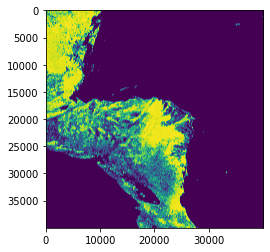

In [12]:
plt.imshow(a)

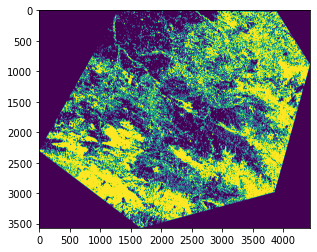

In [13]:
plt.imshow(rasterio.open('/mnt/uksa-storage/land_cover/forest_mask.tif').read(1))